## **Stocex project ipynb file.**

In [1]:
# Necessary libraries
#!pip install yfinance
#!pip install newspaper3k
#!pip install transformers torch
#!pip install yfinance
#!pip install chronos-ts --upgrade --quiet
import json

## ***Step 1*** - Retrieve latest news from NewsAPI

Pull yesterday’s financial news headlines using NewsAPI for the latest market-moving events

In [2]:
# Code to retrieve yesterday news from NewSAPI.

import requests
import pandas as pd
from datetime import datetime, timedelta

# 🔑 Enter your NewsAPI key here
NEWSAPI_KEY = "c32779e494d04276b24ac0eb577c5ca2"

def fetch_yesterdays_news():
    yesterday = datetime.now() - timedelta(days=1)
    date_str = yesterday.strftime("%Y-%m-%d")

    query = (
    "stocks OR stock OR market OR earnings OR inflation OR layoffs OR fed OR economic data "
    "OR acquisition OR merger OR buyout OR billion OR million OR IPO OR funding "
    "OR forecast OR guidance OR quarterly results OR revenue OR profits OR shares "
    "OR dividends OR buybacks OR takeover OR analysts OR downgrade OR upgrade"
    )

    domains = (
        "bloomberg.com,cnn.com,cnbc.com,wsj.com,reuters.com,marketwatch.com,"
        "yahoo.com,investopedia.com,seekingalpha.com,fool.com,fortune.com,"
        "forbes.com,techcrunch.com,businessinsider.com,barrons.com"
    )

    url = (
        f"https://newsapi.org/v2/everything?q={query}"
        f"&from={date_str}&to={date_str}"
        f"&language=en&sortBy=publishedAt"
        f"&pageSize=100"
        f"&domains={domains}"
        f"&apiKey={NEWSAPI_KEY}"
    )

    response = requests.get(url)
    data = response.json()

    if "articles" in data:
        articles = data["articles"]
        df = pd.DataFrame([{
            "title": article["title"],
            "description": article["description"],
            "publishedAt": article["publishedAt"],
            "source": article["source"]["name"]
        } for article in articles])
        return df
    else:
        print("No articles found or error in API call.")
        return pd.DataFrame()

# 🚀 Run it
news_df = fetch_yesterdays_news()
news_df.to_csv("news_headlines.csv", index=False)
news_df.head(10)  # Preview the headlines



,title,description,publishedAt,source
0,Wall Street banks sell final portion of Elon M...,None,2025-04-28T23:45:57Z,Yahoo Entertainment
1,When will we get results of the Canada election?,None,2025-04-28T23:45:22Z,Yahoo Entertainment
2,See the military zone in the Roosevelt Reserva...,The Pentagon is set to control the Roosevelt R...,2025-04-28T23:38:01Z,Business Insider
3,Georges St-Pierre details 'funny relationship'...,Georges St-Pierre sees potential in the reigni...,2025-04-28T23:34:35Z,Yahoo Entertainment
4,Acclaimed Mystery Thriller ‘Drop’ Arrives On S...,“Drop” — a critically acclaimed mystery suspen...,2025-04-28T23:32:38Z,Forbes
5,Positive week for Reliance Worldwide Corporati...,None,2025-04-28T23:30:55Z,Yahoo Entertainment
6,41% Of Employees Say They Have No Time To Lear...,41% of employees say they have no time to lear...,2025-04-28T23:30:50Z,Forbes
7,Greg McElroy Names College Football Star That ...,McElroy compares an overlooked QB to Heisman T...,2025-04-28T23:30:00Z,Yahoo Entertainment
8,Continued job growth could help ward off a rec...,CNBC's Jim Cramer on Monday explained why he t...,2025-04-28T23:28:48Z,CNBC
9,Australia's Fortescue shrugs off disruptions t...,None,2025-04-28T23:28:02Z,Yahoo Entertainment


##***Step 2*** - Extract Tickers from Yesterday’s News

Identify all the stock tickers mentioned in yesterday’s headlines using NLP

In [3]:
import spacy
nlp = spacy.load("en_core_web_sm")


In [4]:
#Loading company names and tickers
import pandas as pd

def load_sp500_tickers():
    url = "https://raw.githubusercontent.com/datasets/s-and-p-500-companies/master/data/constituents.csv"
    df = pd.read_csv(url)

    print("📊 Loaded columns:", df.columns.tolist())  # Debugging

    # Fix column names if needed
    if 'Name' not in df.columns or 'Symbol' not in df.columns:
        if len(df.columns) >= 2:
            df.columns = ['Symbol', 'Name'] + list(df.columns[2:])
        else:
            raise ValueError("CSV does not have expected columns.")

    return {row['Name'].lower(): row['Symbol'] for _, row in df.iterrows()}



In [5]:
# ✅ Named Entity Recognition + Ticker Extraction
def extract_companies_from_articles(news_df, known_companies):
    """
    Extracts company mentions from a DataFrame of news articles and maps them to S&P 500 tickers.

    Args:
        news_df (DataFrame): News articles with 'title' and 'description' columns
        known_companies (dict): Mapping of company names (lowercase) to tickers

    Returns:
        List of matched tickers
    """
    mentioned_tickers = set()
    articles = news_df.to_dict(orient="records")  # ✅ Ensure correct format

    for article in articles:
        text = (article.get("title") or "") + " " + (article.get("description") or "")
        doc = nlp(text)

        for ent in doc.ents:
            if ent.label_ == "ORG":
                company_name = ent.text.lower()
                for known_name, ticker in known_companies.items():
                    if company_name in known_name:  # simple fuzzy match
                        mentioned_tickers.add(ticker)

    return list(mentioned_tickers)

In [6]:
news_df = fetch_yesterdays_news()
known_companies = load_sp500_tickers()

mentioned_tickers = extract_companies_from_articles(news_df, known_companies)
print("🧠 Tickers mentioned in yesterday’s news:", mentioned_tickers)


📊 Loaded columns: ['Symbol', 'Security', 'GICS Sector', 'GICS Sub-Industry', 'Headquarters Location', 'Date added', 'CIK', 'Founded']
🧠 Tickers mentioned in yesterday’s news: ['PSX', 'CMG', 'APD', 'JNPR', 'BALL', 'CBOE', 'MCHP', 'UAL', 'KIM', 'DIS', 'BKR', 'AAPL', 'BA', 'COP', 'PEP', 'MOS', 'LYB', 'AMP', 'AMCR', 'FITB', 'IRM', 'PNR', 'GPN', 'AKAM', 'TDG', 'ABNB', 'FICO', 'EBAY', 'TSLA', 'SPGI', 'LYV', 'PM', 'NOC', 'LUV', 'BAX', 'USB', 'DAL', 'DFS', 'MTB', 'PFG', 'AVB', 'SBUX', 'GWW', 'CPRT', 'WBD', 'BG', 'BAC', 'CARR', 'HBAN', 'SBAC', 'MGM', 'APO', 'FANG', 'CZR', 'PARA', 'ED', 'AMZN', 'EIX']


## ***Step 3*** — Sentiment Analysis with FinBERT
Analyze sentiment of the headlines (from NewsAPI) and any historical headlines you have using FinBERT, a financial-domain BERT model.

In [7]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import numpy as np
from collections import defaultdict

# ✅ Load FinBERT
tokenizer = AutoTokenizer.from_pretrained("yiyanghkust/finbert-tone")
model = AutoModelForSequenceClassification.from_pretrained("yiyanghkust/finbert-tone")

# ✅ Get sentiment for a piece of text
def get_finbert_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1).numpy()[0]
    sentiment_idx = np.argmax(probs)
    sentiment_label = ["negative", "neutral", "positive"][sentiment_idx]
    score = probs[sentiment_idx]
    return sentiment_label, float(score)

# ✅ Score sentiment ONLY for tickers from Step 2 (your extracted tickers)
def score_sentiment_for_mentioned_tickers(news_df, known_companies, mentioned_tickers):
    from collections import defaultdict
    import numpy as np
    import pandas as pd

    # 🔄 Reverse map tickers -> company names
    ticker_to_name = {
        ticker: name
        for name, ticker in known_companies.items()
        if ticker in mentioned_tickers
    }

    sentiment_records = defaultdict(list)

    for _, article in news_df.iterrows():
        text = f"{article.get('title', '')} {article.get('description', '')}".lower()
        sentiment, score = get_finbert_sentiment(text)

        for ticker in mentioned_tickers:
            company_name = ticker_to_name.get(ticker, "").lower()
            if ticker.lower() in text or company_name in text:
                sentiment_records[ticker].append((sentiment, score))

    # 📊 Aggregate results
    results = []
    for ticker, records in sentiment_records.items():
        sentiments = [s for s, _ in records]
        scores = [s for _, s in records]
        avg_score = np.mean(scores)

        # 🪵 Debug print (optional)
        print(f"🔍 {ticker} → Avg Sentiment Score: {avg_score:.3f}")

        if avg_score >= 0.98:  # ✅ Only keep perfect scores
            dominant = max(set(sentiments), key=sentiments.count)
            results.append({
                "Ticker": ticker,
                "Mentions": len(records),
                "Avg Sentiment Score": round(avg_score, 3),
                "Dominant Sentiment": dominant
            })

    # 🛡️ Handle empty result
    df = pd.DataFrame(results)
    if not df.empty:
        df = df.sort_values("Mentions", ascending=False).reset_index(drop=True)
    return df


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/533 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/439M [00:00<?, ?B/s]

In [8]:
sentiment_df = score_sentiment_for_mentioned_tickers(news_df, known_companies, mentioned_tickers)
sentiment_df.to_csv("sentiment_summary.csv", index=False)
print(sentiment_df)

🔍 BA → Avg Sentiment Score: 0.940
🔍 AMP → Avg Sentiment Score: 0.994
🔍 ED → Avg Sentiment Score: 0.942
🔍 PM → Avg Sentiment Score: 0.999
🔍 BALL → Avg Sentiment Score: 0.998
🔍 DIS → Avg Sentiment Score: 0.986
🔍 MOS → Avg Sentiment Score: 0.930
🔍 BAC → Avg Sentiment Score: 0.877
🔍 IRM → Avg Sentiment Score: 1.000
🔍 AMZN → Avg Sentiment Score: 0.640
🔍 UAL → Avg Sentiment Score: 0.998
🔍 COP → Avg Sentiment Score: 1.000
🔍 NOC → Avg Sentiment Score: 1.000
🔍 DFS → Avg Sentiment Score: 1.000
🔍 CARR → Avg Sentiment Score: 1.000
🔍 AAPL → Avg Sentiment Score: 0.724
🔍 SPGI → Avg Sentiment Score: 1.000
   Ticker  Mentions  Avg Sentiment Score Dominant Sentiment
0     DIS         9                0.986           negative
1    BALL         7                0.998           negative
2     AMP         4                0.994           negative
3      PM         3                0.999           negative
4     IRM         2                1.000           negative
5     UAL         2                0.998   

In [10]:
# 📈 Sort by Avg Sentiment Score (descending order)
sentiment_df = sentiment_df.sort_values("Avg Sentiment Score", ascending=False).reset_index(drop=True)

In [11]:
sentiment_df

,Ticker,Mentions,Avg Sentiment Score,Dominant Sentiment
0,DFS,1,1.000,negative
1,COP,1,1.000,neutral
2,IRM,2,1.000,negative
3,CARR,1,1.000,neutral
4,SPGI,1,1.000,positive
5,NOC,1,1.000,neutral
6,PM,3,0.999,negative
7,BALL,7,0.998,negative
8,UAL,2,0.998,negative
9,AMP,4,0.994,negative


# 🧠 Fetch News (Last 30 Days)

In [ ]:
import requests
import pandas as pd
from datetime import datetime, timedelta

# 🔑 Replace this with your actual API key
api_key = "79b7aa20b731467eb7965cced65acc54"

# 📆 Define the time range (last 30 days)
end_date = datetime.now()
start_date = end_date - timedelta(days=30)

# 📰 Topic or stock to search for
query = "nifty50 OR stock market OR NSE India"

# 🌍 Base URL
url = "https://newsapi.org/v2/everything"

# 🧾 Parameters
params = {
    "q": query,
    "from": start_date.strftime('%Y-%m-%d'),
    "to": end_date.strftime('%Y-%m-%d'),
    "sortBy": "publishedAt",
    "language": "en",
    "pageSize": 100,
    "apiKey": api_key,
}

# 📡 Make the request
response = requests.get(url, params=params)
data = response.json()

# ✅ Convert to DataFrame
if data["status"] == "ok":
    articles = data["articles"]
    df = pd.DataFrame([{
        "title": article["title"],
        "publishedAt": article["publishedAt"],
        "description": article["description"],
        "url": article["url"],
        "source": article["source"]["name"]
    } for article in articles])

    print(f"✅ Retrieved {len(df)} news articles.")
    print(df.head())
    # Optional: Save to CSV
    df.to_csv("newsapi_last_30_days.csv", index=False)
else:
    print(f"❌ Error: {data.get('message')}")


✅ Retrieved 100 news articles.
                                               title           publishedAt  \
0  Redmi Watch Move With 1.85-Inch AMOLED Screen,...  2025-04-21T09:00:13Z   
1          World's faithful plunged into mourning...  2025-04-21T09:00:04Z   
2  Nifty may hit 25,500 in two quarters, says ICI...  2025-04-21T08:59:36Z   
3  PM Modi remembers Pope Francis as a "symbol of...  2025-04-21T08:57:51Z   
4  Leather, footwear exports up 25% to $5.7 bn in...  2025-04-21T08:57:45Z   

                                         description  \
0  Redmi Watch Move was launched in India on Mond...   
1  POPE Francis, the leader of the Roman Catholic...   
2  ICICI Securities anticipates a Nifty recovery ...   
3  Prime Minister Narendra Modi expressed profoun...   
4  Council for Leather Exports reports strong dem...   

                                                 url              source  
0  https://www.gadgets360.com/wearables/news/redm...      Gadgets360.com  
1  https://ww

In [9]:
# Fetch only the top 3 tickers with highest sentiment score from sentiment_df

# 📌 Sort by Avg Sentiment Score (descending) and pick top 3
top3_tickers_df = sentiment_df.sort_values("Avg Sentiment Score", ascending=False).head(3)

# 📌 Extract the Ticker list
tickers_to_fetch = top3_tickers_df["Ticker"].dropna().unique().tolist()

print(f"🎯 Top 3 Tickers Selected for Price Fetching: {tickers_to_fetch}")

🎯 Top 3 Tickers Selected for Price Fetching: ['DFS', 'COP', 'IRM']


In [13]:
tickers_to_fetch

['DFS', 'COP', 'IRM']

##***Step 4*** — Fetch historical price data for these tickers using yfinance

Fetch daily stock price data for the tickers extracted from yesterday’s news (sentiment_df) using yfinance, covering the past 5 years.



In [14]:
import os
import pandas as pd
import yfinance as yf

# ✅ This function: Load CSV if exists, else fetch from Yahoo Finance
def load_or_fetch_historical_data(ticker, years=5):
    filename = f"historical_price_data_top3/{ticker}_price_history.csv"
    if os.path.exists(filename):
        print(f"📂 Loading existing historical data for {ticker}")
        df = pd.read_csv(filename)
    else:
        print(f"⬇️ Fetching new data for {ticker} (not found locally)")
        end = pd.Timestamp.today()
        start = end - pd.DateOffset(years=years)
        df = yf.download(ticker, start=start.strftime('%Y-%m-%d'), end=end.strftime('%Y-%m-%d'), progress=False)
        df.reset_index(inplace=True)
        df = df[["Date", "Close"]].rename(columns={"Close": "Price"})
        os.makedirs("historical_price_data_top3", exist_ok=True)
        df.to_csv(filename, index=False)
    return df

# 📦 Load/Fecth Historical Data for Top 3
historical_data = {}

for ticker in tickers_to_fetch:
    historical_data[ticker] = load_or_fetch_historical_data(ticker)

# 👀 Display head(5) for each ticker
for ticker, df in historical_data.items():
    print(f"\n📈 {ticker} - First 5 Rows of Historical Data:\n")
    print(df.head(5))


⬇️ Fetching new data for DFS (not found locally)
YF.download() has changed argument auto_adjust default to True
⬇️ Fetching new data for COP (not found locally)
⬇️ Fetching new data for IRM (not found locally)

📈 DFS - First 5 Rows of Historical Data:

Price        Date      Price
Ticker                   DFS
0      2020-04-29  40.902428
1      2020-04-30  38.283100
2      2020-05-01  36.857613
3      2020-05-04  36.857613
4      2020-05-05  36.617062

📈 COP - First 5 Rows of Historical Data:

Price        Date      Price
Ticker                   COP
0      2020-04-29  35.030678
1      2020-04-30  34.939388
2      2020-05-01  32.482849
3      2020-05-04  33.495338
4      2020-05-05  33.960087

📈 IRM - First 5 Rows of Historical Data:

Price        Date      Price
Ticker                   IRM
0      2020-04-29  19.466770
1      2020-04-30  18.865997
2      2020-05-01  18.413462
3      2020-05-04  17.882904
4      2020-05-05  17.586414


## ***Step 5*** - Forecast for next 1 Week with TimeGPT

In [26]:
# ✅ INSTALL (if not done)
!pip install nixtla --quiet
!pip install utilsforecast --quiet
!pip install yfinance matplotlib --quiet

In [27]:
# ✅ IMPORTS
import yfinance as yf
import pandas as pd
from nixtla import NixtlaClient
from utilsforecast.preprocessing import fill_gaps
import matplotlib.pyplot as plt
import os

In [28]:
# ✅ Setup TimeGPT Client
client = NixtlaClient(api_key="nixak-Cy1l2cVcBmGLFNxQGpF6g8XLJTWBUpVY3CIuZ4aKHaU2of7h7c6SRj0UD77hjR86HHdeYw06d05JIhbB")  # your key


In [34]:
# ✅ Imports already done above
# ✅ Assume TimeGPT client is already connected
# ✅ Assume tickers_to_fetch is already defined (like ['COP', 'IRM', 'NOC'])

# ✅ Updated and Correct Forecasting Function
def forecast_from_existing_csv(ticker, horizon=5):
    print(f"\n🔍 Processing {ticker}...")

    path = f"historical_price_data_top3/{ticker}_price_history.csv"
    if not os.path.exists(path):
        print(f"❌ File not found for {ticker}. Skipping.")
        return None

    # 📂 Step 1: Load CSV
    df = pd.read_csv(path)

    # 🧹 Step 2: Drop the first junk row
    df = df.drop(index=0).reset_index(drop=True)

    # 🧹 Step 3: Rename columns
    df = df.rename(columns={"Date": "ds", "Price": "y"})

    # 🧹 Step 4: Force 'y' to numeric type
    df['y'] = pd.to_numeric(df['y'], errors='coerce')

    # 🧹 Step 5: Drop any remaining NaN
    df = df.dropna(subset=["ds", "y"])

    # 🧹 Step 6: Datetime conversion
    df['ds'] = pd.to_datetime(df['ds'])

    # 🧹 Step 7: Add unique_id column for TimeGPT
    df['unique_id'] = ticker
    df = df[['unique_id', 'ds', 'y']]

    # 🧹 Step 8: Fill missing dates and interpolate
    df_filled = fill_gaps(df, freq='D')
    df_filled['y'] = df_filled['y'].interpolate(method='linear', limit_direction='both')

    # 🔮 Step 9: Forecast using TimeGPT
    forecast_df = client.forecast(
        df=df_filled,
        h=horizon,
        freq='D',
        model='timegpt-1'
    )

    # ✅ Return forecasted DataFrame
    return forecast_df

# ✅ Now run for all tickers
forecasts = {}

for ticker in tickers_to_fetch:
    forecast_df = forecast_from_existing_csv(ticker)
    forecasts[ticker] = forecast_df

    # ✅ Print the forecasted values
    if forecast_df is not None:
        print(f"\n📈 Forecasted values for {ticker}:\n")
        print(forecast_df)



🔍 Processing AAPL...

📈 Forecasted values for AAPL:

  unique_id         ds    TimeGPT
0      AAPL 2025-04-29  209.61697
1      AAPL 2025-04-30  211.20790
2      AAPL 2025-05-01  210.52298
3      AAPL 2025-05-02  209.35046
4      AAPL 2025-05-03  208.88443

🔍 Processing MSFT...

📈 Forecasted values for MSFT:

  unique_id         ds    TimeGPT
0      MSFT 2025-04-29  392.32663
1      MSFT 2025-04-30  392.63940
2      MSFT 2025-05-01  391.44507
3      MSFT 2025-05-02  388.96330
4      MSFT 2025-05-03  387.20060

🔍 Processing GOOGL...

📈 Forecasted values for GOOGL:

  unique_id         ds    TimeGPT
0     GOOGL 2025-04-29  161.21468
1     GOOGL 2025-04-30  161.55540
2     GOOGL 2025-05-01  160.65456
3     GOOGL 2025-05-02  159.67963
4     GOOGL 2025-05-03  159.12330

🔍 Processing AMZN...

📈 Forecasted values for AMZN:

  unique_id         ds    TimeGPT
0      AMZN 2025-04-29  187.99051
1      AMZN 2025-04-30  188.95744
2      AMZN 2025-05-01  187.18066
3      AMZN 2025-05-02  185.50024



📊 Plotting AAPL...


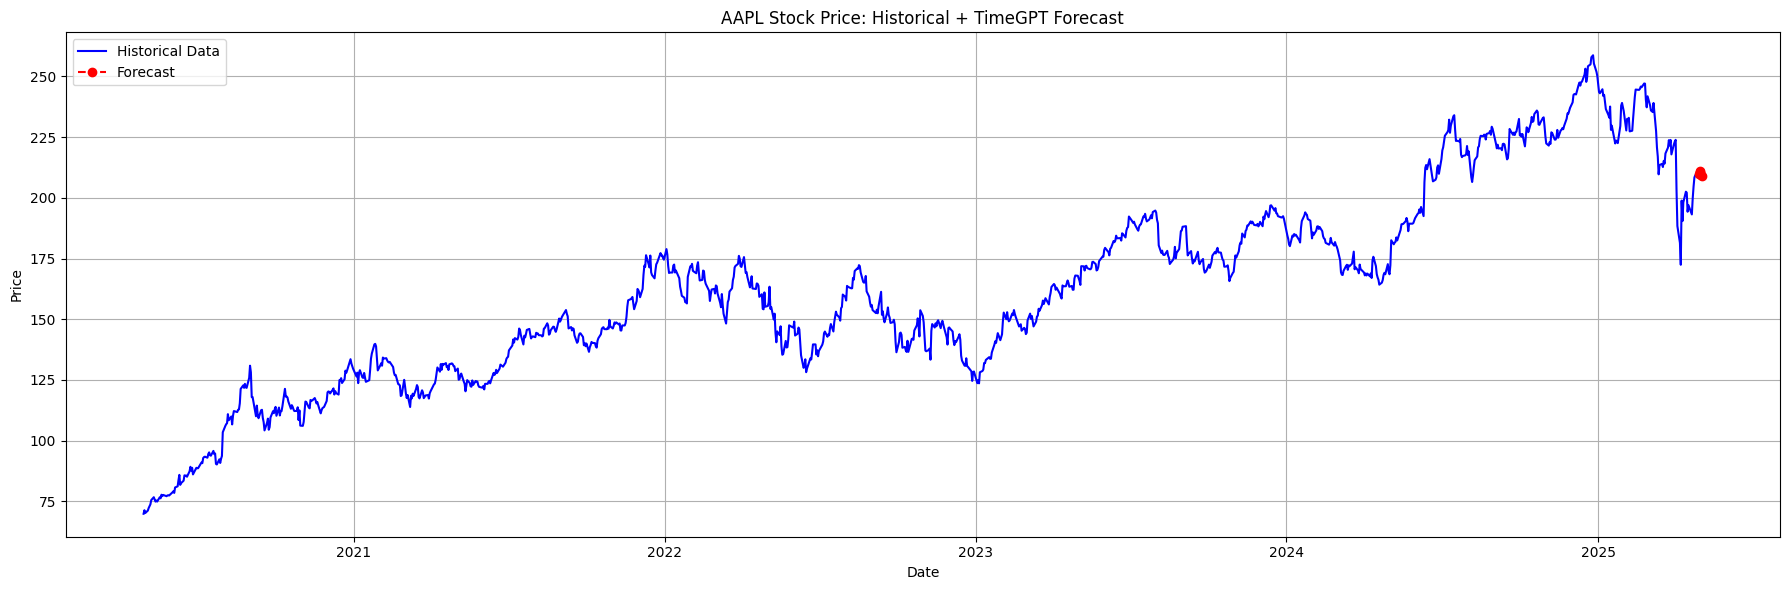


📊 Plotting MSFT...


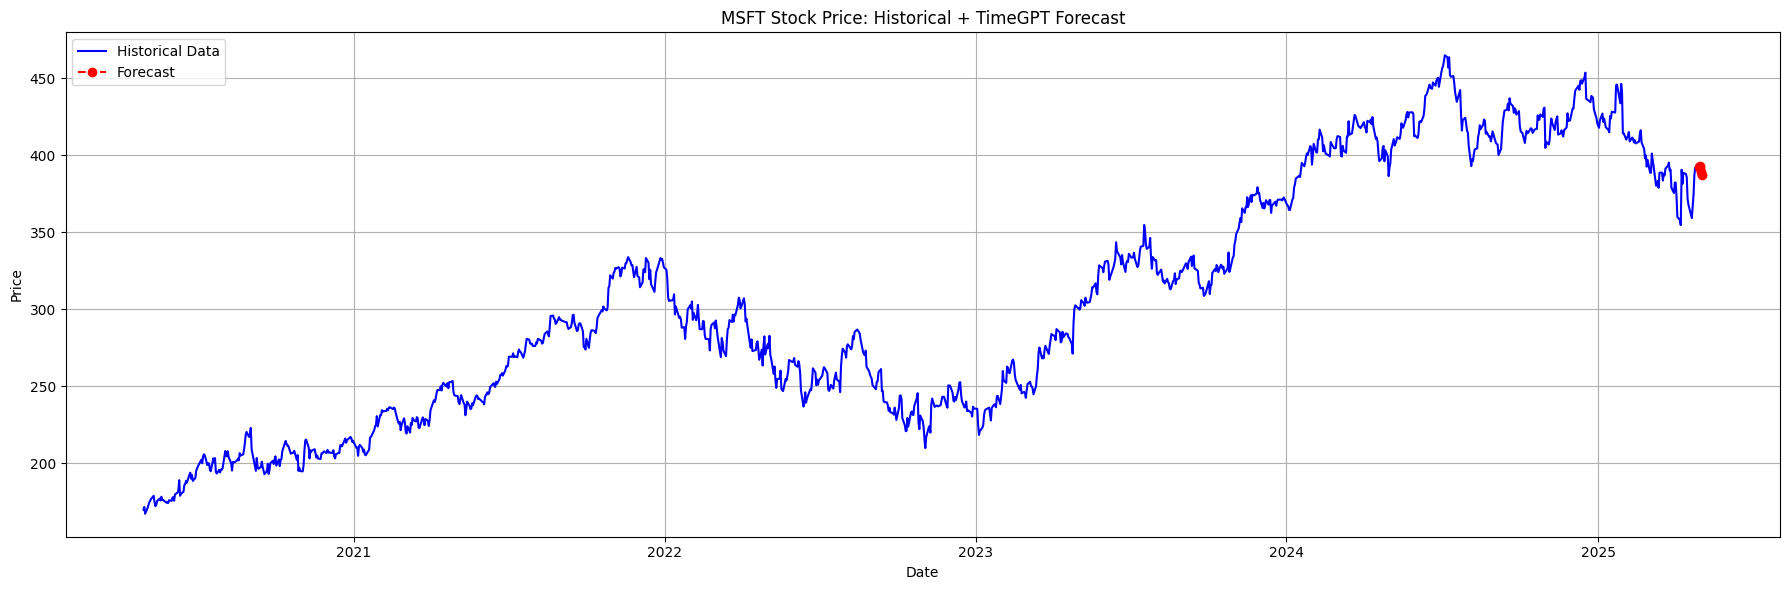


📊 Plotting GOOGL...


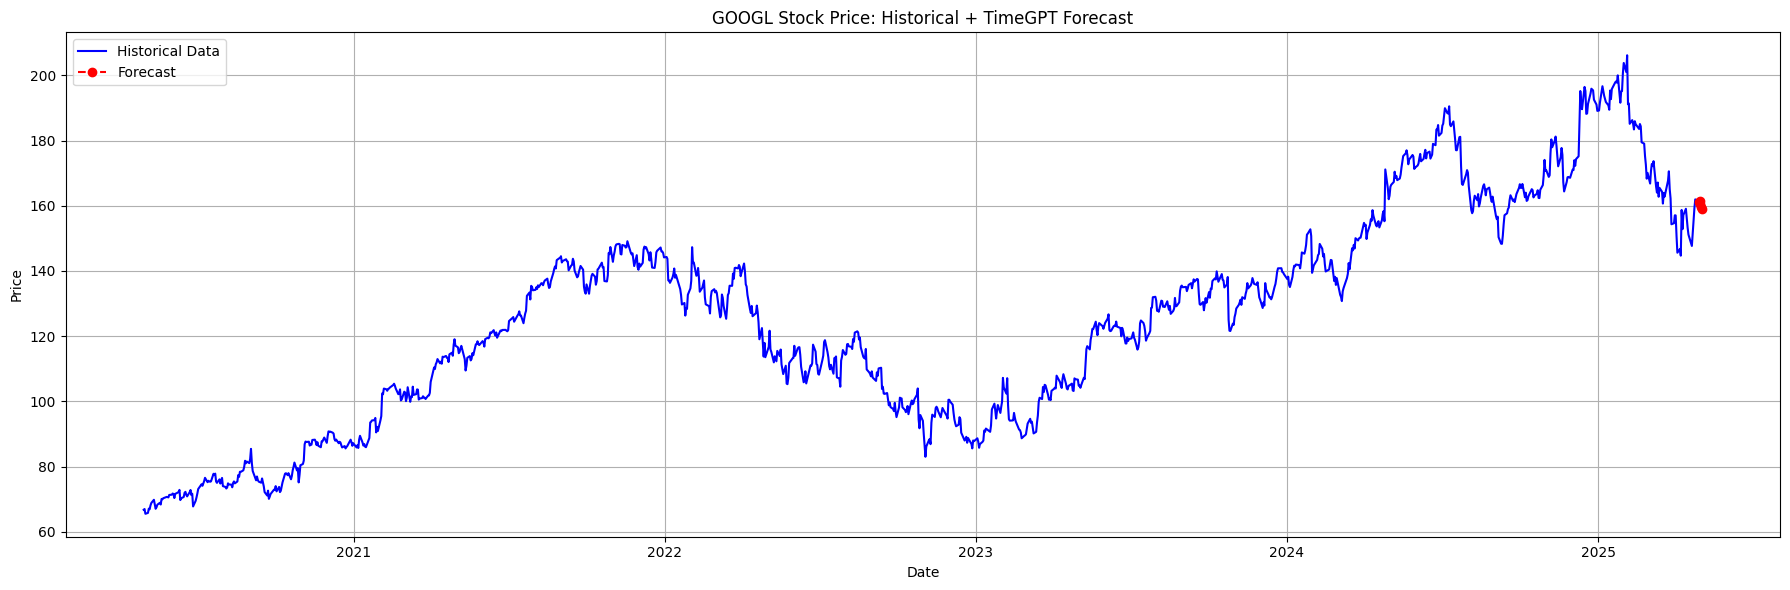


📊 Plotting AMZN...


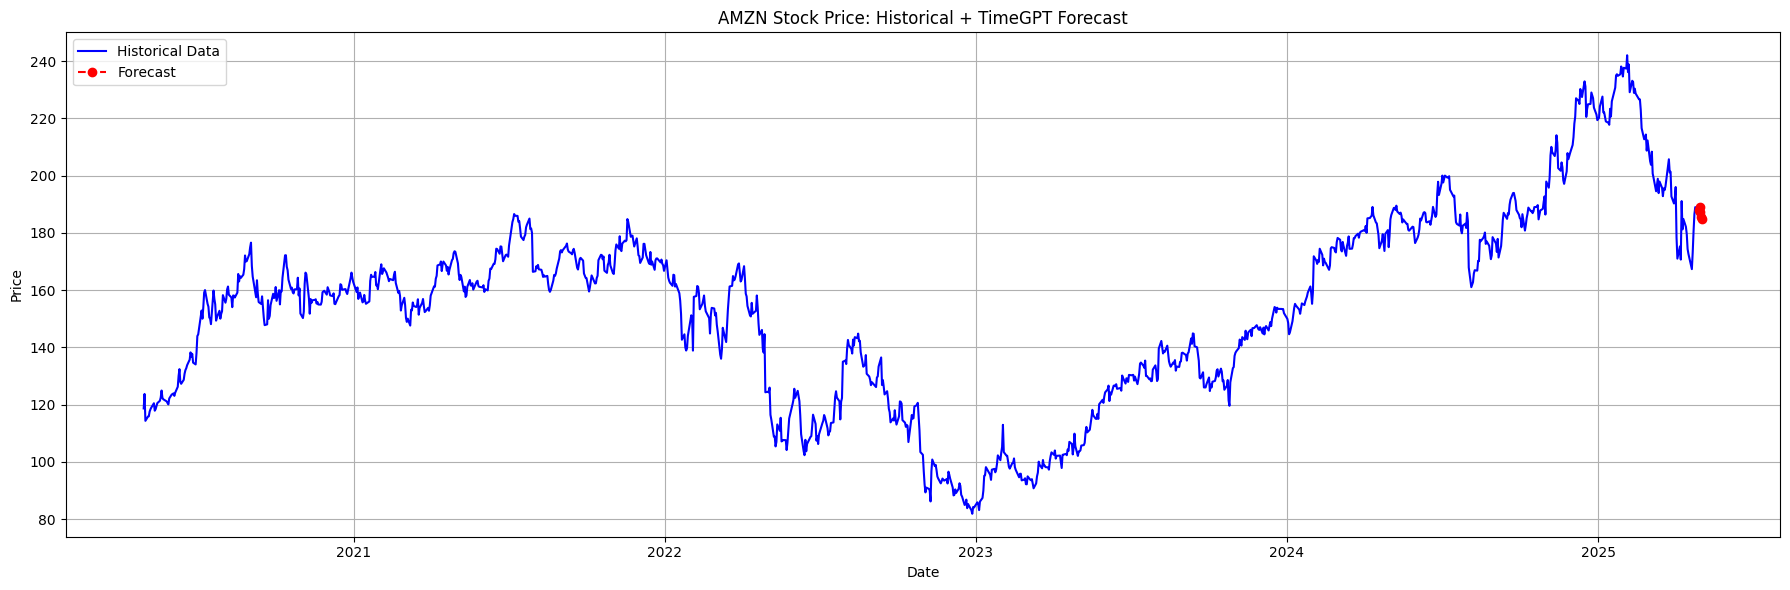


📊 Plotting TSLA...


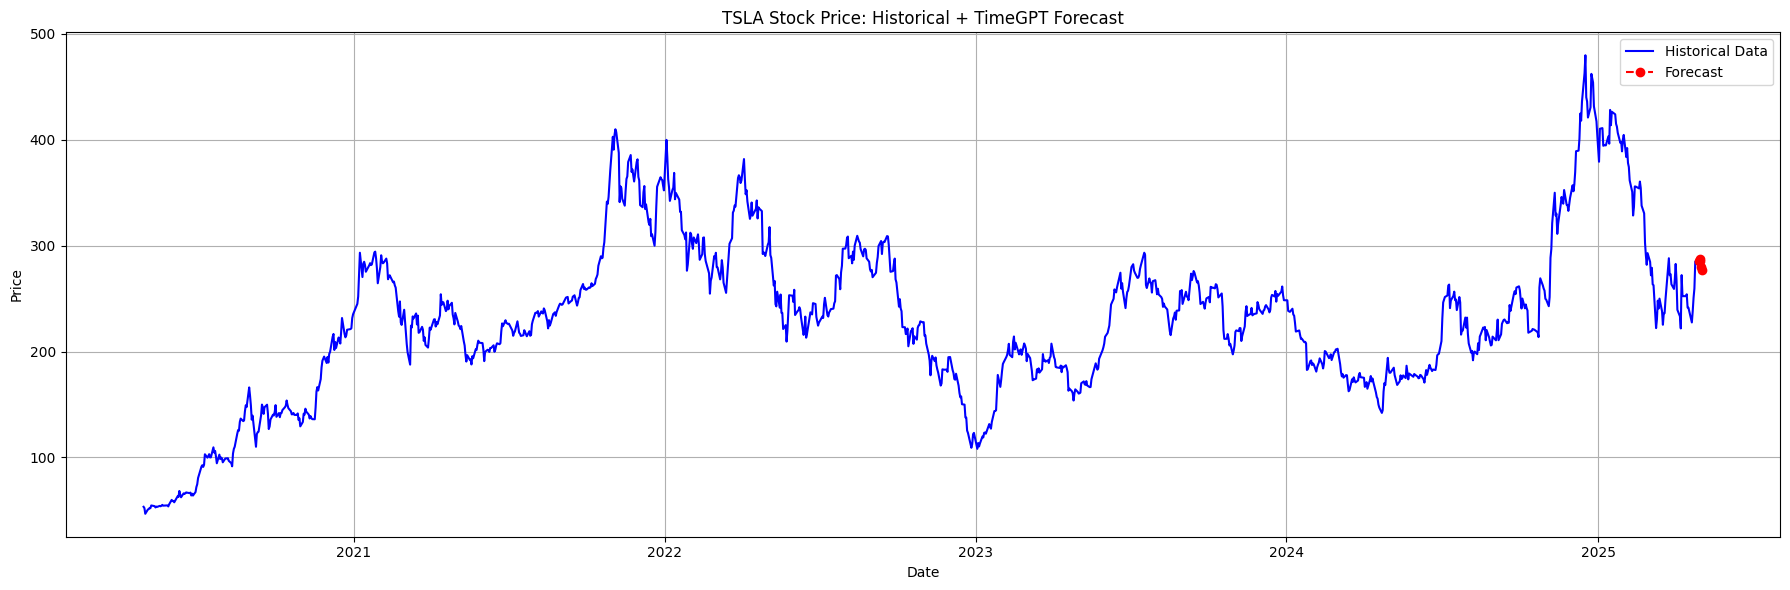


📊 Plotting META...


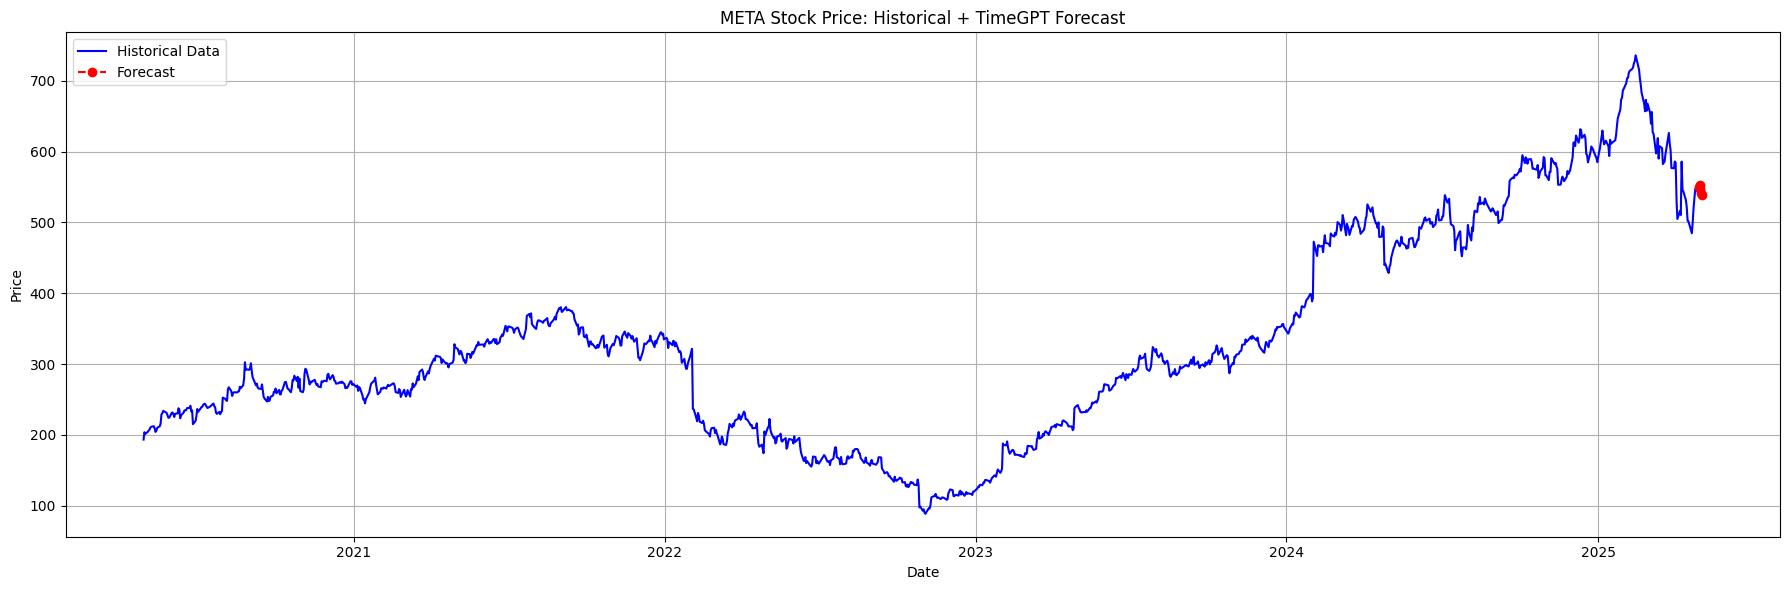


📊 Plotting NFLX...


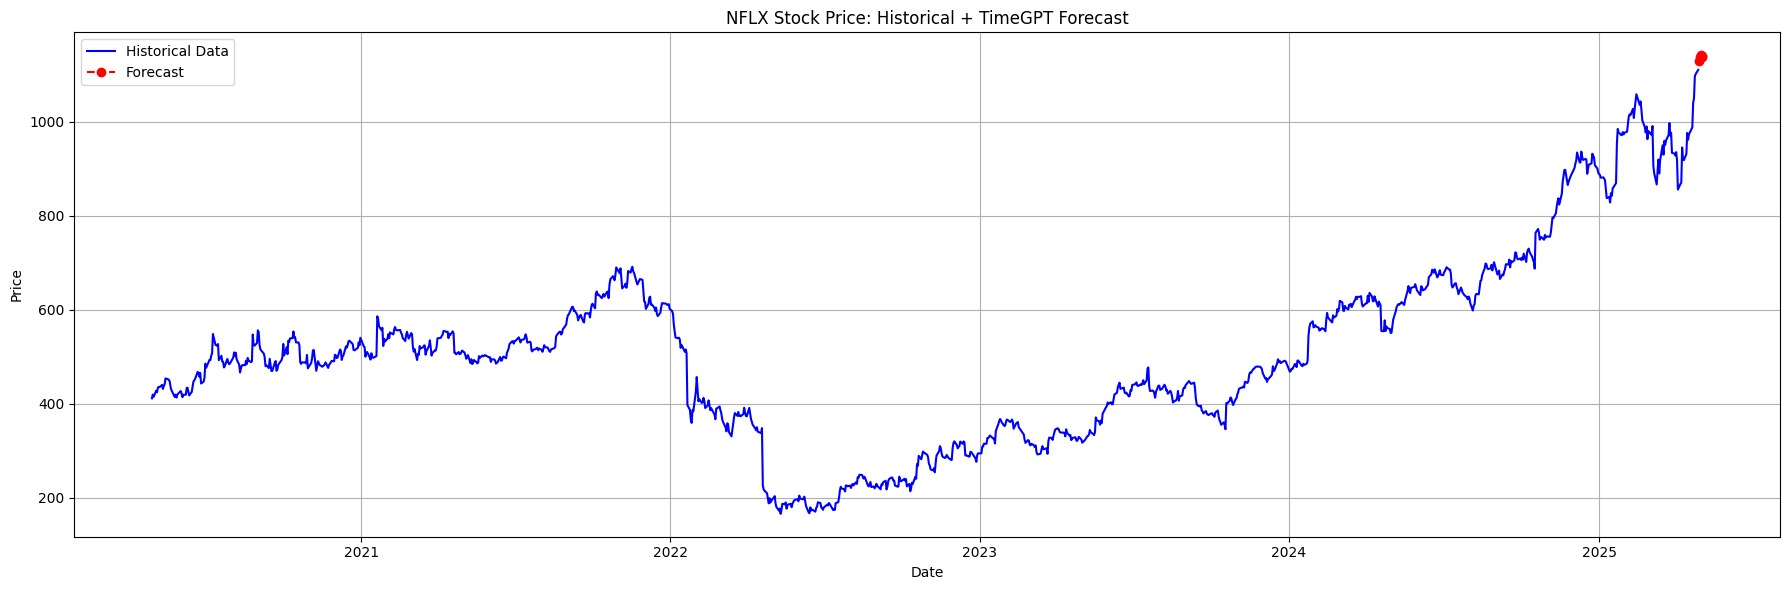

In [35]:
import matplotlib.pyplot as plt
import pandas as pd
import os

# ✅ New plotting function
def plot_historical_and_forecast(ticker, historical_folder="historical_price_data_top3/", forecast_horizon=5):
    print(f"\n📊 Plotting {ticker}...")

    # Load Historical CSV
    historical_path = os.path.join(historical_folder, f"{ticker}_price_history.csv")
    if not os.path.exists(historical_path):
        print(f"❌ Historical data not found for {ticker}. Skipping.")
        return

    hist_df = pd.read_csv(historical_path)

    # Drop junk first row
    hist_df = hist_df.drop(index=0).reset_index(drop=True)

    # Rename columns
    hist_df = hist_df.rename(columns={"Date": "ds", "Price": "y"})

    # Force y to numeric
    hist_df['y'] = pd.to_numeric(hist_df['y'], errors='coerce')
    hist_df = hist_df.dropna(subset=["ds", "y"])

    # Convert ds to datetime
    hist_df['ds'] = pd.to_datetime(hist_df['ds'])

    # Get forecasted data from dictionary
    forecast_df = forecasts.get(ticker)
    if forecast_df is None:
        print(f"❌ No forecast available for {ticker}. Skipping plot.")
        return

    # Create plot
    plt.figure(figsize=(18,6))

    # Plot historical
    plt.plot(hist_df['ds'], hist_df['y'], label='Historical Data', color='blue')

    # Plot forecasted (join from end of historical)
    plt.plot(forecast_df['ds'], forecast_df['TimeGPT'], label='Forecast', color='red', linestyle='--', marker='o')

    # Styling
    plt.title(f'{ticker} Stock Price: Historical + TimeGPT Forecast')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    plt.show()

# ✅ Now plot for all tickers
for ticker in tickers_to_fetch:
    plot_historical_and_forecast(ticker)


# Calculating Z Score

In [36]:
import numpy as np

# ✅ Define function to calculate Z-Scores, Absolute Error, Confidence Intervals
def calculate_forecast_metrics(ticker, historical_folder="historical_price_data_top3/"):
    print(f"\n📈 Calculating metrics for {ticker}...")

    # Load historical data
    hist_path = os.path.join(historical_folder, f"{ticker}_price_history.csv")
    if not os.path.exists(hist_path):
        print(f"❌ Historical data missing for {ticker}. Skipping metrics.")
        return None

    hist_df = pd.read_csv(hist_path)
    hist_df = hist_df.drop(index=0).reset_index(drop=True)
    hist_df = hist_df.rename(columns={"Date": "ds", "Price": "y"})
    hist_df['y'] = pd.to_numeric(hist_df['y'], errors='coerce')
    hist_df = hist_df.dropna(subset=["ds", "y"])
    hist_df['ds'] = pd.to_datetime(hist_df['ds'])

    # Load forecast
    forecast_df = forecasts.get(ticker)
    if forecast_df is None:
        print(f"❌ No forecast available for {ticker}. Skipping metrics.")
        return None

    # ✅ Step 1: Calculate Historical Mean and Std Dev
    mean_y = hist_df['y'].mean()
    std_y = hist_df['y'].std()

    # ✅ Step 2: Z-Score for each forecasted value
    forecast_df['z_score'] = (forecast_df['TimeGPT'] - mean_y) / std_y

    # ✅ Step 3: Absolute Error compared to last actual historical point
    last_actual = hist_df['y'].iloc[-1]
    forecast_df['absolute_error'] = np.abs(forecast_df['TimeGPT'] - last_actual)

    # ✅ Step 4: Confidence Intervals (assuming normal distribution)
    ci_80 = 1.28 * std_y  # 80% confidence
    ci_90 = 1.64 * std_y  # 90% confidence
    ci_95 = 1.96 * std_y  # 95% confidence

    forecast_df['lower_95'] = forecast_df['TimeGPT'] - ci_95
    forecast_df['upper_95'] = forecast_df['TimeGPT'] + ci_95

    forecast_df['lower_90'] = forecast_df['TimeGPT'] - ci_90
    forecast_df['upper_90'] = forecast_df['TimeGPT'] + ci_90

    forecast_df['lower_80'] = forecast_df['TimeGPT'] - ci_80
    forecast_df['upper_80'] = forecast_df['TimeGPT'] + ci_80

    # ✅ Done
    return forecast_df

# ✅ Now run it for all tickers
forecast_with_metrics = {}

for ticker in tickers_to_fetch:
    forecast_metrics_df = calculate_forecast_metrics(ticker)
    forecast_with_metrics[ticker] = forecast_metrics_df

    if forecast_metrics_df is not None:
        print(f"\n📈 Forecast + Metrics for {ticker}:\n")
        print(forecast_metrics_df[['ds', 'TimeGPT', 'z_score', 'absolute_error', 'lower_95', 'upper_95']])



📈 Calculating metrics for AAPL...

📈 Forecast + Metrics for AAPL:

          ds    TimeGPT   z_score  absolute_error    lower_95    upper_95
0 2025-04-29  209.61697  1.197755        0.523029  131.688838  287.545102
1 2025-04-30  211.20790  1.237769        1.067901  133.279768  289.136032
2 2025-05-01  210.52298  1.220542        0.382981  132.594848  288.451112
3 2025-05-02  209.35046  1.191051        0.789539  131.422328  287.278592
4 2025-05-03  208.88443  1.179330        1.255569  130.956298  286.812562

📈 Calculating metrics for MSFT...

📈 Forecast + Metrics for MSFT:

          ds    TimeGPT   z_score  absolute_error    lower_95    upper_95
0 2025-04-29  392.32663  1.124665        1.166626  238.313821  546.339439
1 2025-04-30  392.63940  1.128646        1.479396  238.626591  546.652209
2 2025-05-01  391.44507  1.113446        0.285066  237.432261  545.457879
3 2025-05-02  388.96330  1.081863        2.196704  234.950491  542.976109
4 2025-05-03  387.20060  1.059430        3.959404 

# Superposed Epoch Analysis

In [37]:
import numpy as np

# ✅ Superposed Epoch Analysis function
def superposed_epoch_analysis(historical_df, forecast_df, days_before=5, days_after=5):
    """
    historical_df: DataFrame with 'ds', 'y'
    forecast_df: DataFrame with 'ds', 'TimeGPT'
    days_before: how many days before forecast to align
    days_after: how many days after forecast to align
    """
    # Convert historical ds to datetime if not already
    historical_df['ds'] = pd.to_datetime(historical_df['ds'])
    forecast_df['ds'] = pd.to_datetime(forecast_df['ds'])

    # Prepare list to collect aligned data
    aligned_curves = []

    for forecast_date in forecast_df['ds']:
        start_window = forecast_date - pd.Timedelta(days=days_before)
        end_window = forecast_date + pd.Timedelta(days=days_after)

        # Subset historical data around forecast date
        window = historical_df[(historical_df['ds'] >= start_window) & (historical_df['ds'] <= end_window)]

        # Align index: -days_before to +days_after
        window = window.copy()
        window['epoch_day'] = (window['ds'] - forecast_date).dt.days
        window = window.set_index('epoch_day')

        # Save the 'y' values
        aligned_curves.append(window['y'])

    # Combine all aligned curves into one DataFrame
    aligned_df = pd.concat(aligned_curves, axis=1)

    # Calculate mean and std across aligned curves
    mean_curve = aligned_df.mean(axis=1)
    std_curve = aligned_df.std(axis=1)

    return mean_curve, std_curve



🔎 SEA for AAPL...


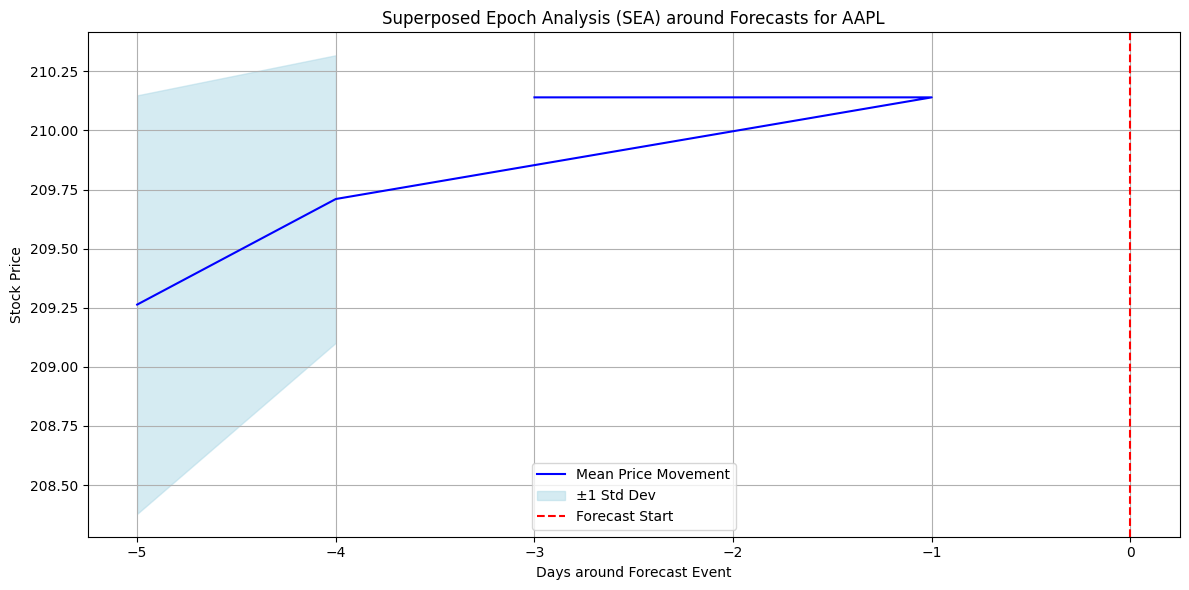


🔎 SEA for MSFT...


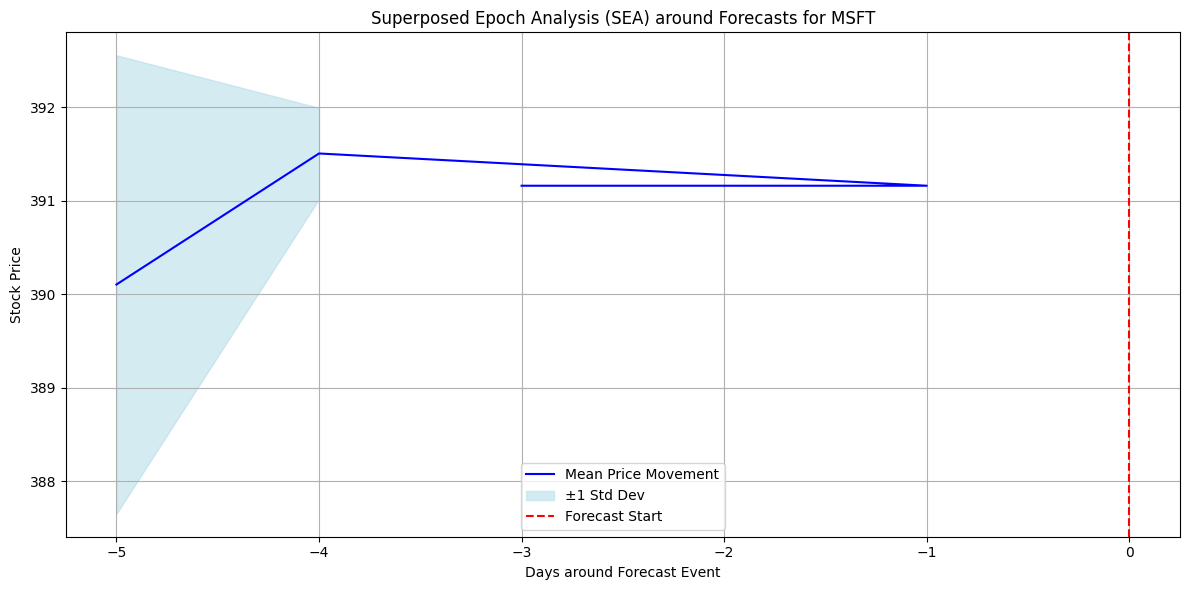


🔎 SEA for GOOGL...


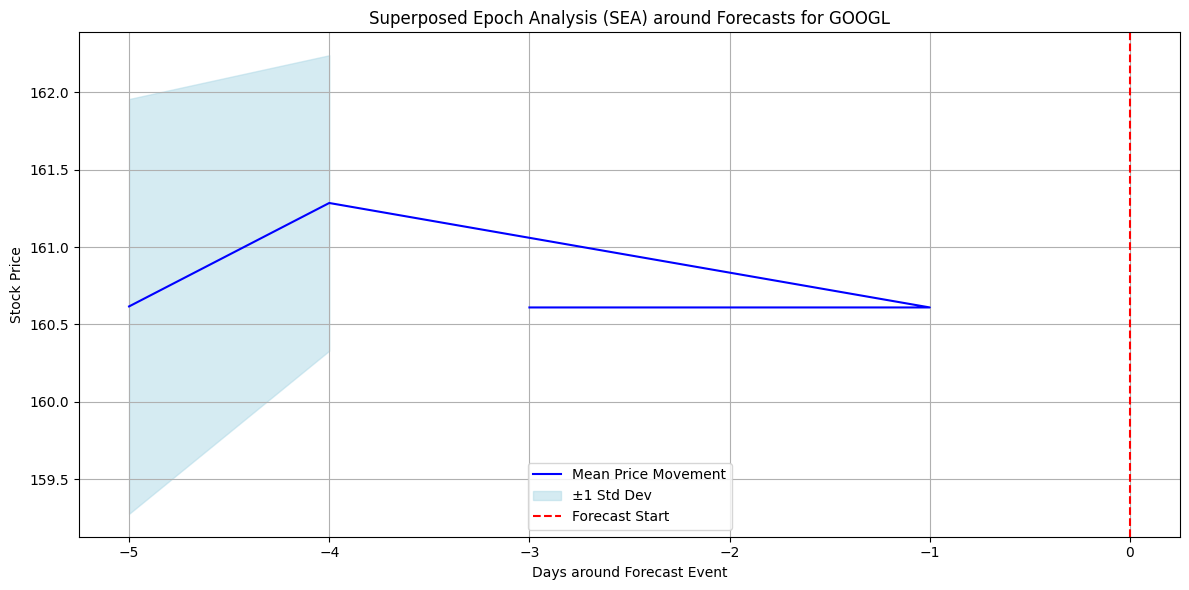


🔎 SEA for AMZN...


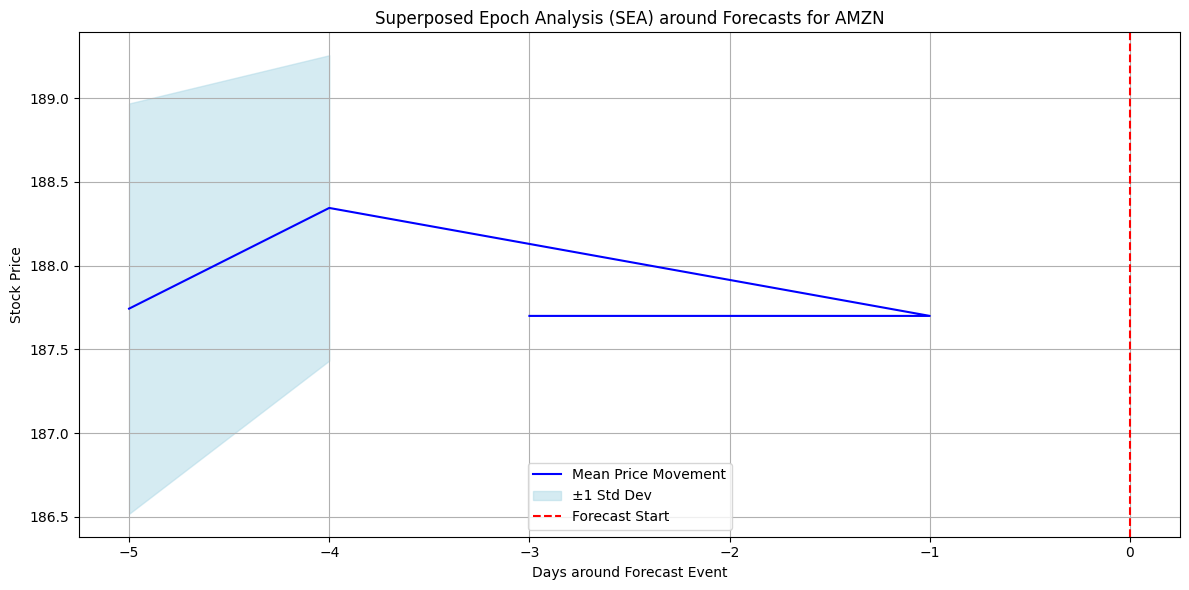


🔎 SEA for TSLA...


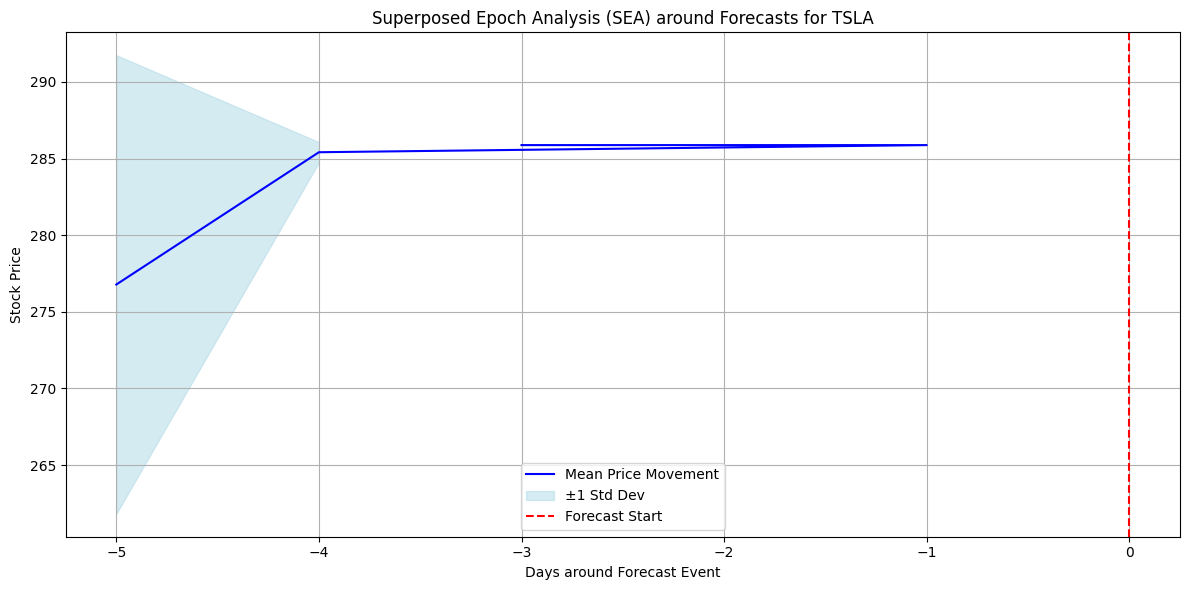


🔎 SEA for META...


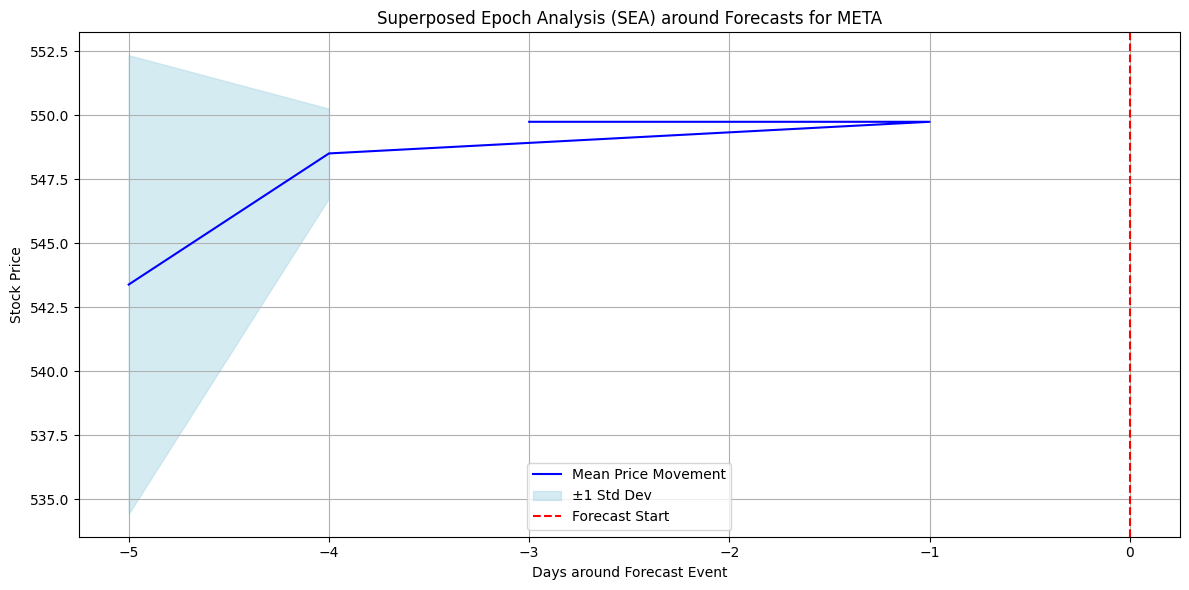


🔎 SEA for NFLX...


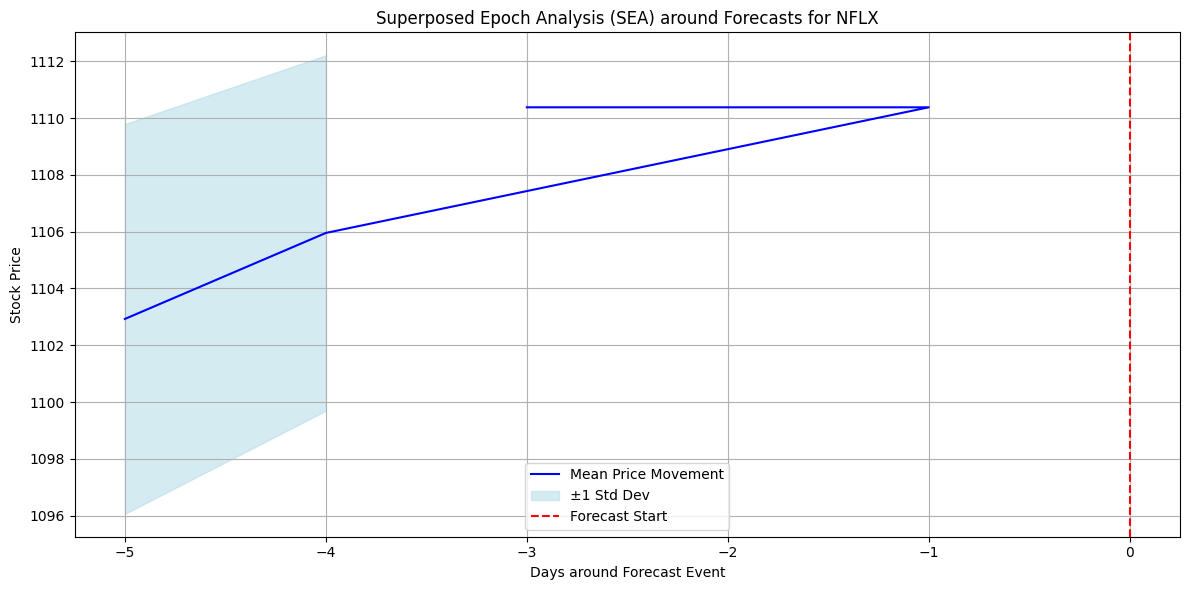

In [38]:
# 📦 Run SEA on all tickers
for ticker in tickers_to_fetch:
    print(f"\n🔎 SEA for {ticker}...")

    # Load historical
    hist_path = f"historical_price_data_top3/{ticker}_price_history.csv"
    if not os.path.exists(hist_path):
        continue

    hist_df = pd.read_csv(hist_path)
    hist_df = hist_df.drop(index=0).reset_index(drop=True)
    hist_df = hist_df.rename(columns={"Date": "ds", "Price": "y"})
    hist_df['y'] = pd.to_numeric(hist_df['y'], errors='coerce')
    hist_df = hist_df.dropna(subset=["ds", "y"])
    hist_df['ds'] = pd.to_datetime(hist_df['ds'])

    # Get forecasted points
    forecast_df = forecast_with_metrics.get(ticker)
    if forecast_df is None:
        continue

    # Run SEA
    mean_curve, std_curve = superposed_epoch_analysis(hist_df, forecast_df, days_before=5, days_after=5)

    # ✅ Plot the SEA result
    plt.figure(figsize=(12,6))
    plt.plot(mean_curve.index, mean_curve.values, label='Mean Price Movement', color='blue')
    plt.fill_between(mean_curve.index,
                     mean_curve - std_curve,
                     mean_curve + std_curve,
                     color='lightblue', alpha=0.5, label='±1 Std Dev')

    plt.axvline(0, color='red', linestyle='--', label='Forecast Start')
    plt.title(f'Superposed Epoch Analysis (SEA) around Forecasts for {ticker}')
    plt.xlabel('Days around Forecast Event')
    plt.ylabel('Stock Price')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
